In [1]:
!python -V

Python 3.8.3


In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
import gc

from pathlib import Path
PATH = Path('../..') # proj_news_viz/nlp
sys.path.append(str(PATH))

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

---
возьмем для примера датасет [News dataset from Lenta.Ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta), скаченный по url с [github](https://github.com/yutkin/Lenta.Ru-News-Dataset/tree/v1.1)

или выполнить следующие 2 команды в нужной вам директории:

`$ wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2`

`$ bzip2 -d lenta-ru-news.csv.bz2`

In [4]:
df = pd.read_csv(PATH / 'data/external/lenta-ru-news.csv')
print(f'{df.shape = }')
df.sample(2)

df.shape = (800975, 6)


,url,title,text,topic,tags,date
542782,https://lenta.ru/news/2015/04/10/puma/,В Ростовском зоопарке неизвестные вынесли из к...,В Ростовском зоопарке неизвестные усыпили пуму...,Из жизни,Звери,2015/04/10
473991,https://lenta.ru/news/2013/07/25/train/,Как минимум 10 человек погибли при крушении по...,Как минимум десять человек погибли в результат...,Мир,Происшествия,2013/07/25


In [5]:
# удалим пустые записи и дубликаты по признаку `text`

df = df.dropna()
df.text.drop_duplicates(inplace=True)

print(f'{df.shape = }')
df.isnull().sum()

df.shape = (712654, 6)


url      0
title    0
text     0
topic    0
tags     0
date     0
dtype: int64

In [6]:
# посмотрим какие самые старые и новые статьи мы имеем
print(f'{df.date.min() = }\n{df.date.max() = }')

df.date.min() = '1914/09/16'
df.date.max() = '2018/12/15'


In [7]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
df.topic.value_counts()

уникальное к-ство разделов: 23


Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [8]:
# выберем для примера топ-5 разделов
top_topics = 5
df_top = df[df.topic.isin(df.topic.value_counts().head(top_topics).index)]
df_top.shape

(479471, 6)

In [9]:
print(f'{df_top.date.min() = }\n{df_top.date.max() = }')

df_top.date.min() = '1999/08/31'
df_top.date.max() = '2018/12/15'


---
разделим данные для начала на train & test в соотношении 80/20 соответственно  со стратификацией по топиках

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_top.text,df_top.topic,
                                                    test_size=0.2,
                                                    stratify=df_top.topic,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383576,), (95895,), (383576,), (95895,))

In [12]:
# проверим на пустые значения
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
# добавим самописный файл, для отображения топ частотный слов
from news_viz.visualization.plot_frequency import plotFrequencyWords

* ### без препроцессинга

In [15]:
%%time

tfidf_vect = TfidfVectorizer()

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 1min 8s, sys: 787 ms, total: 1min 9s
Wall time: 1min 9s


In [16]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 734629

пример [:5]: [('на', 15871.815508813179), ('по', 10774.821058601865), ('что', 10639.430590100452), ('не', 8267.292710162437), ('из', 6925.430609163202)]


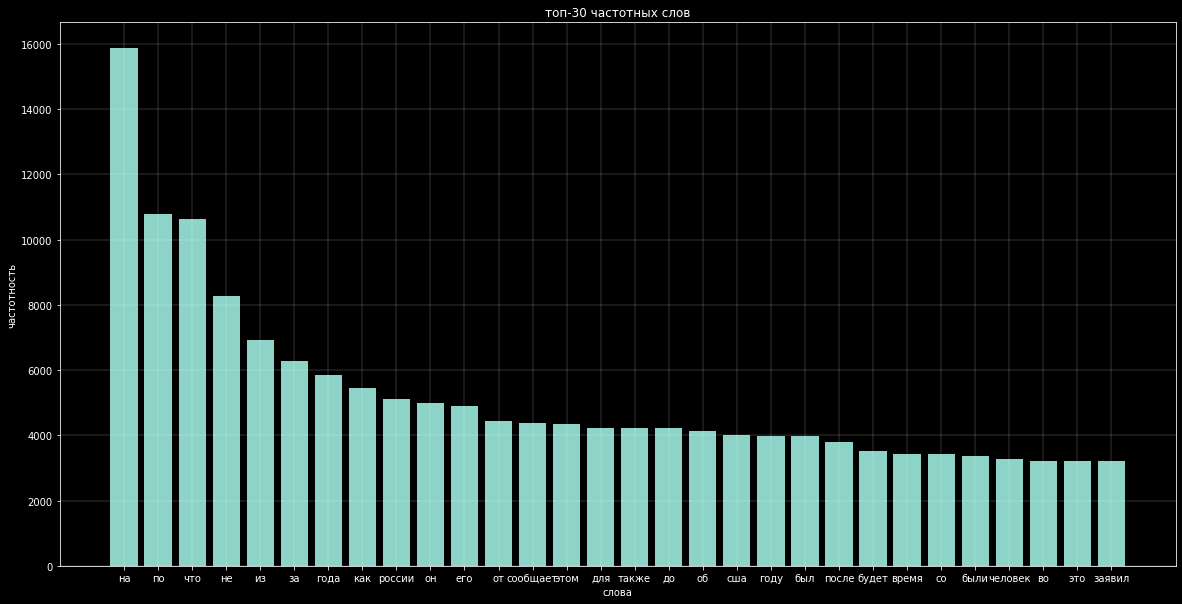

In [17]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [18]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.92715   0.96170   0.94411     10706
         Мир    0.89456   0.91070   0.90256     27324
      Россия    0.91902   0.87749   0.89777     31001
       Спорт    0.97936   0.97953   0.97945     11579
   Экономика    0.90995   0.94014   0.92480     15285

    accuracy                        0.91866     95895
   macro avg    0.92601   0.93391   0.92974     95895
weighted avg    0.91880   0.91866   0.91848     95895

confusion_matrix:
[[10296   160   206    13    31]
 [  360 24884  1581    62   437]
 [  360  2373 27203   131   934]
 [   31    86   100 11342    20]
 [   58   314   510    33 14370]]
CPU times: user 6min 38s, sys: 9min 17s, total: 15min 56s
Wall time: 3min 36s


In [19]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', TfidfVectorizer()),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

* ### c препроцессингом

In [20]:
# импортируем кастомный наш препроцессинг
from news_viz.data.preprocessing_tools import clean_text, lemmatize
# pip install pymorphy2

In [21]:
lemmatize(clean_text(df.loc[np.random.randint(df.shape[0])][2]))

'два бриллиант общий стоимость свыше одиннадцать половина евро 14 1 миллион доллар сша похитить музейный комплекс лувр сообщать france presse драгоценный камень представить экспозиция торговый дом ювелирный изделие chopard 22 биеннале антиквар парижский carrousel du louvre по данные предварительный расследование вероятный украсть сотрудник отлучиться стенд драгоценность 15 минута вор разбить стекло стенд забрать бриллиант 47 карат стоимость примерно евро камень 30 карат стоимость пять половина евро похититель удаться незамеченный покинуть преступление по слово полицейский зал располагаться стенд chopard использоваться торговый выставочный мероприятие установить камера видеонаблюдение сигнализация биеннале проходить 15 сентябрь 28 сентябрь на выставка представить знаменитый алмаз звезда юг star south 128 48 карат выставить торговый дом cartier продажа'

In [22]:
# импортируем нужные нам библиотеки для мультипроцессинга
# создаем соответствующую для этого функцию
import multiprocessing as mp
from multiprocessing import Pool

num_cores = mp.cpu_count() # number of cores on your machine; 20
num_partitions = num_cores * 2 # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [23]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* оставим только слова

In [24]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [25]:
%%time

print('cleaning train `text` & dropping missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text != 'TOREMOVE']

print('cleaning train `text` & dropping missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text != 'TOREMOVE']

gc.collect()

cleaning train `text` & dropping missing rows ...
cleaning train `text` & dropping missing rows ...
CPU times: user 9.61 s, sys: 7.96 s, total: 17.6 s
Wall time: 17.5 s


24

* лемматизируем и удалим заодно стоп-слова

In [26]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatize)
    return data

In [27]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text != 'TOREMOVE']

gc.collect()

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text != 'TOREMOVE']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 17.2 s, sys: 13 s, total: 30.2 s
Wall time: 9min 37s


0

In [32]:
print(f'{train.lemma_text.isnull().sum() = }\n{test.lemma_text.isnull().sum() = }')
print()
print(f'{train.shape = }\n{test.shape = }')

train.sample(2)

train.lemma_text.isnull().sum() = 0
test.lemma_text.isnull().sum() = 0

train.shape = (382928, 4)
test.shape = (95710, 4)


,text,target,clean_text,lemma_text
341981,Бывший глава администрации президента Александ...,Экономика,Бывший глава администрации президента Александ...,бывший глава администрация президент александр...
254510,"За неделю до премьеры фильма ""Австралия"" его р...",Культура,За неделю до премьеры фильма Австралия его реж...,за неделя премьера фильм австралия режиссёр ба...


---
_на случай, если не хватает памяти_

In [ ]:
train[['lemma_text','target']].to_csv(PATH / 'data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(PATH / 'data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [ ]:
# соответственно нужно выполнить после перезапуска этого ноутбука
train = pd.read_csv(PATH / 'data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(PATH / 'data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip')

In [ ]:
print(train.shape, test.shape)
train.sample(2)

---
* обучаем модель на очищенных данных

In [33]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [34]:
%%time

tfidf_vect_vect = TfidfVectorizer()

tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_test = tfidf_vect.transform(X_test)

CPU times: user 45.7 s, sys: 485 ms, total: 46.1 s
Wall time: 46.2 s


In [35]:
# распределение токенов
vocab = {a: b for a, b in zip(tfidf_vect.get_feature_names(), np.ravel(tfidf_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))

print(f'размер корпуса: {len(vocab)}')
print(f'\nпример [:5]: {vocab[:5]}')

размер корпуса: 387870

пример [:5]: [('россия', 6859.347294415302), ('по', 5680.787080102596), ('сообщать', 4951.672070278981), ('российский', 4475.244209821559), ('страна', 4435.059934957456)]


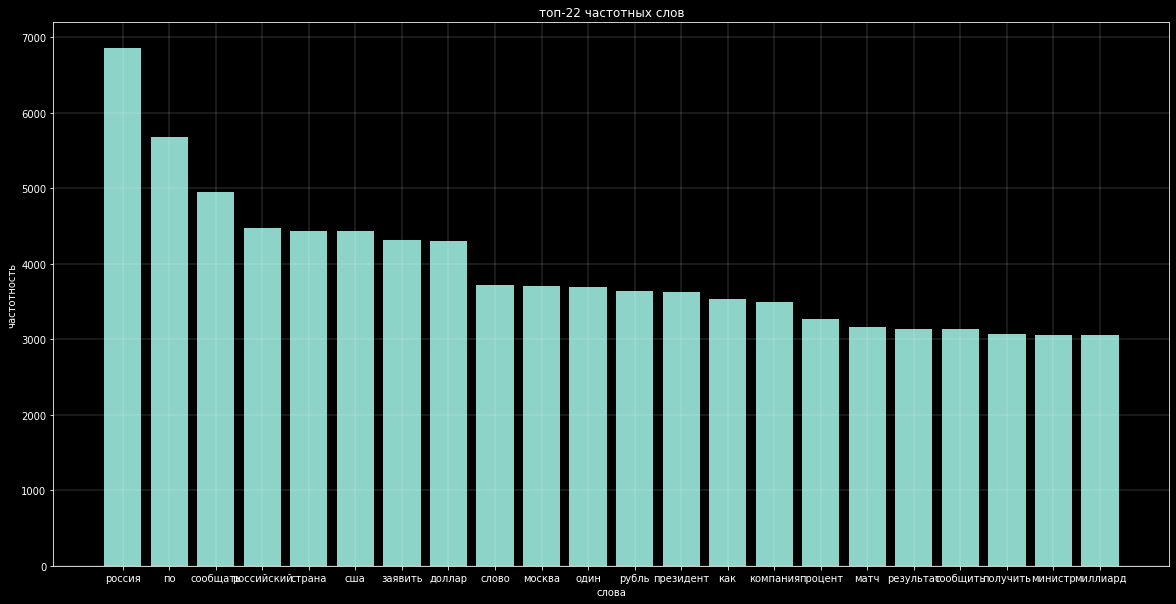

In [36]:
plotFrequencyWords(vocab = vocab,
                   top_words = 22,
                   plt_background = 'dark')

In [37]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(tfidf_vect_train, y_train)

pred_lr = lr.predict(tfidf_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.93017   0.96833   0.94887     10703
         Мир    0.90059   0.90723   0.90390     27262
      Россия    0.91939   0.87833   0.89839     30904
       Спорт    0.97726   0.98384   0.98054     11575
   Экономика    0.90520   0.94445   0.92441     15266

    accuracy                        0.91994     95710
   macro avg    0.92652   0.93644   0.93122     95710
weighted avg    0.91998   0.91994   0.91969     95710

confusion_matrix:
[[10364   128   168    15    28]
 [  333 24733  1635    76   485]
 [  375  2266 27144   139   980]
 [   26    58    86 11388    17]
 [   44   278   491    35 14418]]
CPU times: user 4min 14s, sys: 8min 12s, total: 12min 27s
Wall time: 1min 55s
